# Supplementary Analysis Notebook 3: Benchmarking Causal Forests with the partial confounder test

Also available on [github](https://github.com/pni-lab/mlconfound-manuscript/blob/main/empirical/supplement/causal_forest.ipynb).
https://github.com/pni-lab/mlconfound-manuscript/blob/main/empirical/supplement/causal_forest.ipynb

In [15]:
#!pip install causalml econml
import numpy as np
from causalml.dataset import simulate_nuisance_and_easy_treatment
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from  econml.grf import CausalForest
from sklearn.model_selection import KFold
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from mlconfound.stats import partial_confound_test
from mlconfound.plot import plot_graph


# Causal Forest on simulated data

In [16]:
# Generate synthetic data for single simulation
np.random.seed(42)
y, X, treatment, tau, b, e = simulate_nuisance_and_easy_treatment(n=5000)

In [17]:
# Estimate a baseline RandomForest and a causal forest
base_model = DecisionTreeRegressor(random_state=42)
base_model.fit(y=y[:4000], # crime rate
              X=X[:4000] # features
             )

cf_model = CausalForest(random_state=42)
cf_model.fit(y=y[:4000], # crime rate
              T=treatment[:4000], # percent male
              X=X[:4000] # features
             )

predicted_base = base_model.predict(X[4000:])
predicted_cf = cf_model.predict_full(X[4000:])[:,1]

<AxesSubplot:>

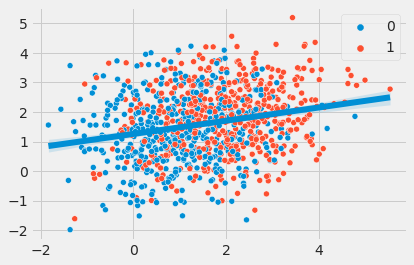

In [18]:
sns.regplot(x=y[4000:], y=predicted_base, scatter=False)
sns.scatterplot(x=y[4000:], y=predicted_base.flatten(), hue=treatment[4000:])

Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 327.84it/s]


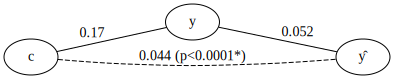

In [19]:
plot_graph(partial_confound_test(y=y[4000:], yhat=predicted_base.flatten(), c=treatment[4000:], cat_c=True))

<AxesSubplot:>

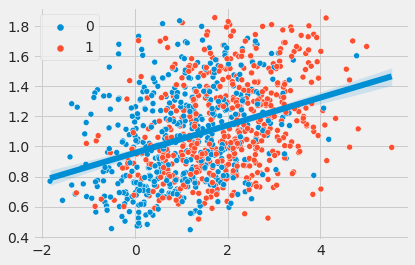

In [20]:
sns.regplot(x=y[4000:], y=predicted_cf, scatter=False)
sns.scatterplot(x=y[4000:], y=predicted_cf.flatten(), hue=treatment[4000:])

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 334.67it/s]


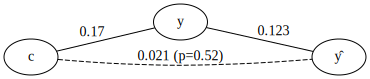

In [21]:
plot_graph(partial_confound_test(y=y[4000:], yhat=predicted_cf.flatten(), c=treatment[4000:], cat_c=True))

### Causal forest seems to successfully eliminate confounder bias in simulated data.

# Now we try it for the HCP dataset

In [22]:
# HCP data can be obtained from the connectomeDB with special license
# data is not part of this repository
subjectIDs = pd.read_csv('../data/hcp/subjectIDs.txt', header=None)
netmats_parcor = pd.read_csv('../data/hcp/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)
behavior = pd.read_csv('../data/hcp/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age

In [23]:
##########################################################
# change these
target = 'PMAT24_A_CR' # fluid intelligence
feature_data = netmats_parcor
########################################################### it's a good practice to use pandas for merging, messing up subject order can be painful
features = feature_data.columns
df = behavior
df = df.merge(feature_data, left_index=True, right_index=True, how='left')
df = df.dropna(subset = [target] + features.values.tolist())
y = df[target].values
X = df[features].values
rng = np.random.default_rng(42)
y_trf = quantile_transform(np.array([y+rng.uniform(0,1,len(y))-0.5]).T, output_distribution='normal', n_quantiles=1000).flatten()
y=y_trf

In [24]:
model = CausalForest()
# nested cv
outer_cv = KFold(10)
predicted = np.zeros(len(y))
for train, test in outer_cv.split(X, y):
    model.fit(X=X[train], y=y[train], T=df.Acquisition.astype("category").cat.codes.values[train])
    predicted[test] = model.predict_full(X[test])[:,1].flatten()

*** Score on mean as model:	-1.0401469064852684
Explained Variance: -0.028955156207362664
Correlation: 0.05018535195483551


<AxesSubplot:>

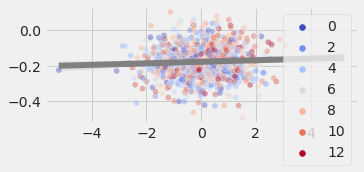

In [25]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("Explained Variance: " +  str( 1- -mean_squared_error(predicted, y)/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 565.55it/s]


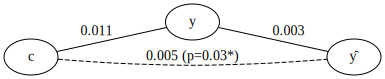

In [26]:
plot_graph(partial_confound_test(y, predicted, df.Acquisition.astype("category").cat.codes.values,
                                     random_state=42))